In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

### Data Cleaning

In [2]:
# Get the images files from our data set
path_data_set = './dataset/players/'

img_dirs = []

#getting the individual paths for each folder in path_data_set
for entry in os.scandir(path_data_set):
    if entry.is_dir():
        img_dirs.append(entry.path)
print(img_dirs)
print(len(img_dirs))

['./dataset/players/cassio', './dataset/players/diego_souza', './dataset/players/fred', './dataset/players/gabriel_barbosa', './dataset/players/german_cano', './dataset/players/hulk', './dataset/players/marinho']
7


In [3]:
#Checking the quantites of images in each folder

for img_dir in img_dirs:
    player_name = img_dir.split('/')[-1] #./dataset/cassio , it will get the last element after split it. (cassio)
    images = os.listdir(img_dir)
    images_quantity = len(images)
    print(f"The total images in {player_name} folder are {images_quantity}.")

The total images in cassio folder are 171.
The total images in diego_souza folder are 266.
The total images in fred folder are 187.
The total images in gabriel_barbosa folder are 187.
The total images in german_cano folder are 189.
The total images in hulk folder are 167.
The total images in marinho folder are 190.


### As we can see, the hulk folder has the minimum images, 167

In [4]:
#renaming all the images to a pattern: name_player 1, name_player 2, etc...

for img_dir in img_dirs:
    player_name = img_dir.split('/')[-1]
    
    for count, filename in enumerate(os.listdir(img_dir)):
        filename_split = filename.split('.')    
        new_file_name = f"{player_name} {str(count)}.jpg"
        source =f"{img_dir}/{filename}"  # foldername/filename
        destination =f"{img_dir}/{new_file_name}"

        # rename() function will rename all the files
        os.rename(source, destination)

In [5]:
#creating a new folder called test.
import shutil

path_data_set_test = './dataset/test'
if os.path.exists(path_data_set_test): #if this folder already exists, it will remove it
    shutil.rmtree(path_data_set_test)
os.mkdir(path_data_set_test) #creating the new folder

In [6]:
#Defining minimum number of images for training and validation equal to 165 (less than 167). The remain will be stored to test folder to test our model.
min_images = 165

for img_dir in img_dirs:
    for count, filename in enumerate(os.listdir(img_dir)):
        if count >= min_images:
            source = img_dir + '/' +  str(filename)
            destination = path_data_set_test + '/' +  str(filename)
            shutil.move(source, destination)

In [7]:
#Running again to check the quantities now.
#Creating also a variable players_file_names_dict which attributes the indexes for each player

players_file_names_dict = {}
count = 0

for img_dir in img_dirs:
    player_name = img_dir.split('/')[-1]
    
    players_file_names_dict[player_name] = count
    count += 1
    
    images = os.listdir(img_dir)
    images_quantity = len(images)
    print(f"The total images in {player_name} folder are {images_quantity}.")

print(players_file_names_dict)

The total images in cassio folder are 165.
The total images in diego_souza folder are 165.
The total images in fred folder are 165.
The total images in gabriel_barbosa folder are 165.
The total images in german_cano folder are 165.
The total images in hulk folder are 165.
The total images in marinho folder are 165.
{'cassio': 0, 'diego_souza': 1, 'fred': 2, 'gabriel_barbosa': 3, 'german_cano': 4, 'hulk': 5, 'marinho': 6}


## Spliting our images into training and validation

In [8]:
import splitfolders

# 80% training and 20% validation
dst = './dataset/'
splitfolders.ratio(path_data_set, output = dst, seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 1155 files [00:10, 109.06 files/s]


In [10]:
#the path of each directory

train_dir = os.path.join(dst, 'train')
validation_dir = os.path.join(dst, 'val')
test_dir = os.path.join(dst, 'test')

print(train_dir)

# Get number of files in each directory
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

print(total_train)
print(total_test)

./dataset/train
924
202


In [11]:
# Variables for pre-processing and training.
batch_size = 16
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

### Using ImageDataGenerator class in order to perform image augmentation to get a better accuracy.

In [12]:
#Parameters below defined to modify our images.

train_image_generator = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")

validation_image_generator = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")

test_image_generator = ImageDataGenerator(
        rescale=1 / 255.0)

#taking a path of the directories and generates batches of augmented data.

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="rgb", #the image has three color channels, set “rgb”
    batch_size=batch_size,
    class_mode="categorical", #as we have seven classes to predict
    shuffle=True,
    seed=42)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42)

test_data_gen = test_image_generator.flow_from_directory(
    directory=dst, #Path due to it can’t find any classes because test has no subdirectories.
    classes=['test'], #specify the parent directory of the test directory and specify that you only want to load the test “class”.
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None, #None, to return only the images.
    shuffle=False, #This will make sure the final predictions stay is in the order that our test expects.
    seed=42)

Found 924 images belonging to 7 classes.
Found 231 images belonging to 7 classes.
Found 202 images belonging to 1 classes.


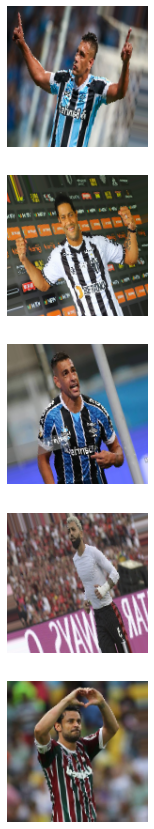

In [68]:
#The plotImages function will be used a few times to plot images.
#It takes an array of images, probabilities and indices lists, although the probabilities and indices lists are optional.

def plotImages(images_arr, probabilities = False, indeces = None, players_file_names_dict = None):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, probability, indece, ax in zip(images_arr, probabilities, indeces, axes):
            ax.imshow(img)
            ax.axis('off')
            
            #getting the name by the index with the higher probability
            name_player = [k for k, v in players_file_names_dict.items() if v == indece]
            #name_player return a list. Ex: ['cassio']
            ax.set_title("%.2f" % (probability*100) + "% " + name_player[0])
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [29]:
#Recreate the train_image_generator using ImageDataGenerator because there are a small number of training examples, so there is a risk of overfitting.

train_image_generator = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")

Found 924 images belonging to 7 classes.


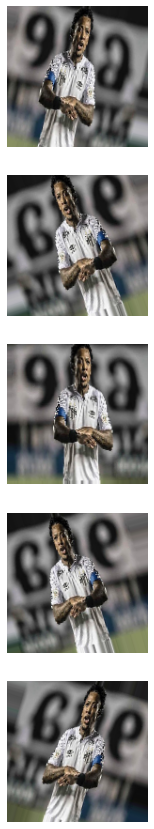

In [32]:
# A single image is plotted five times different using different variations.

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="rgb", #the image has three color channels, set “rgb”
    batch_size=batch_size,
    class_mode="categorical", #as we have seven classes to predict
    shuffle=True,
    seed=42)

augmented_images = [train_data_gen[0][0][1] for i in range(5)]

plotImages(augmented_images)

### Creating the model

In [33]:
#convolutional base
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) #do not need put the input shape because it will figure out automatically the size from the previous layer
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

#after extracted features, add layers to classify them
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))
#softmax activation function to return the probability distributuion for each class. Softmax is used for multi-class classification tasks.

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 73984)             0

In [34]:
STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size
STEP_SIZE_VALID=val_data_gen.n//val_data_gen.batch_size

history = model.fit(train_data_gen, epochs=epochs, steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID,
                    validation_data=val_data_gen)

Epoch 1/10
57/57 [==============================] - 51s 871ms/step - loss: 1.8907 - accuracy: 0.2104 - val_loss: 1.6402 - val_accuracy: 0.4330
Epoch 2/10
57/57 [==============================] - 40s 704ms/step - loss: 1.5217 - accuracy: 0.4493 - val_loss: 1.2833 - val_accuracy: 0.5580
Epoch 3/10
57/57 [==============================] - 41s 716ms/step - loss: 1.3134 - accuracy: 0.5154 - val_loss: 1.0488 - val_accuracy: 0.6741
Epoch 4/10
57/57 [==============================] - 40s 704ms/step - loss: 1.0535 - accuracy: 0.6267 - val_loss: 0.9713 - val_accuracy: 0.6027
Epoch 5/10
57/57 [==============================] - 41s 719ms/step - loss: 0.9534 - accuracy: 0.6751 - val_loss: 0.8204 - val_accuracy: 0.7589
Epoch 6/10
57/57 [==============================] - 40s 702ms/step - loss: 0.8849 - accuracy: 0.7026 - val_loss: 0.8991 - val_accuracy: 0.6830
Epoch 7/10
57/57 [==============================] - 41s 710ms/step - loss: 0.8080 - accuracy: 0.7181 - val_loss: 0.7976 - val_accuracy: 0.7098

### Checking its performance

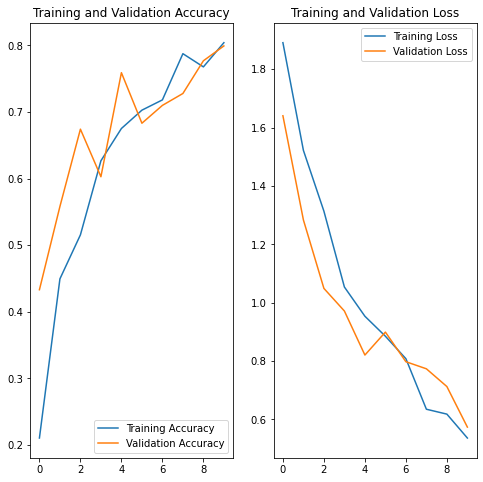

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predicting the output

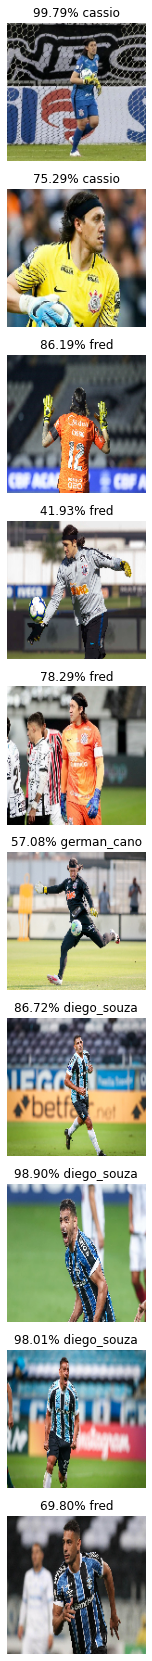

In [71]:
#reset the test_generator before whenever you call the predict_generator. This is important, if you forget to reset the test_generator you will get outputs in a weird order.
test_data_gen.reset()
pred = model.predict(test_data_gen)

#getting a list with the max porcentage for each prediticion 
predicted_class_porcentages = np.max(pred,axis=1)

#getting a list with the index with the max porcentage for each prediticion, to match the index with the players_file_names_dict
predicted_class_indeces = np.argmax(pred, axis=1)

#Calling the plotImages function (def plotImages(images_arr, probabilities = False, indeces = None, players_file_names_dict = None))
sample_testing_images = next(test_data_gen)
plotImages(sample_testing_images[:10], probabilities=predicted_class_porcentages, indeces=predicted_class_indeces, players_file_names_dict=players_file_names_dict)

### Let's compare with the same images the CNN model and the Logistic Regression model which used Haar Cascades technique.

In [98]:
new_test_image_generator = ImageDataGenerator(
        rescale=1 / 255.0)

new_test_data_gen = new_test_image_generator.flow_from_directory(
    directory=dst, #Path due to it can’t find any classes because test has no subdirectories.
    classes=['test_images'], #The same images which were test
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None, #None, to return only the images.
    shuffle=False, #This will make sure the final predictions stay is in the order that our test expects.
    seed=42)

Found 4 images belonging to 1 classes.


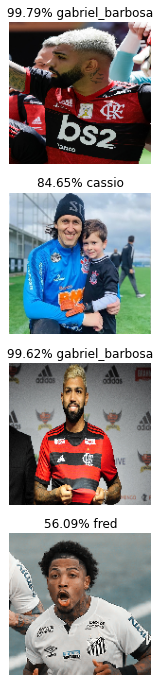

In [99]:
#reset the test_generator before whenever you call the predict_generator. This is important, if you forget to reset the test_generator you will get outputs in a weird order.
new_test_data_gen.reset()
pred = model.predict(new_test_data_gen)

#getting a list with the max porcentage for each prediticion 
predicted_class_porcentages = np.max(pred,axis=1)

#getting a list with the index with the max porcentage for each prediticion, to match the index with the players_file_names_dict
predicted_class_indeces = np.argmax(pred, axis=1)

#Calling the plotImages function (def plotImages(images_arr, probabilities = False, indeces = None, players_file_names_dict = None))
sample_testing_images = next(new_test_data_gen)
plotImages(sample_testing_images, probabilities=predicted_class_porcentages, indeces=predicted_class_indeces, players_file_names_dict=players_file_names_dict)

### Although we trained our model using small number of images, we get a reasonable accuracy.

In [95]:
#Saving the Model to JSON

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
